In [1]:
!pip install matplotlib seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 1단계: 데이터 로드 및 병합


In [ ]:
import pandas as pd
import os

def load_and_preprocess_data():
    """
    [1단계: 데이터 로드 및 병합]
    '../data/preprocessing/' 폴더에서 모든 CSV 파일을 로드하고 '지역구' 기준으로 병합하는 함수.
    
    -   목표: '개선 시급도'라는 단일 시점(Snapshot) 지수를 만듭니다.
    -   기준 시점 (2023-2024년):
        Pro님의 말씀대로 일부 파일(예: X13_독거노인, Y15_경찰관)은 2020-2024년 데이터를 포함합니다.
        하지만 핵심 데이터인 '성범죄 발생 건수(X03)'와 'CCTV(Y06)' 등은 2023년 기준의 단일 시점 데이터입니다.
        따라서, 논리적인 비교를 위해 모든 변수를 '현재 시점'으로 통일하며,
        연도별 데이터가 있는 파일에서는 가장 최신 연도(2023년 또는 2024년)의 데이터를 선택합니다.
        -   원본 데이터는 읽기만 하며, 훼손하지 않습니다.
    """
    print("--- 1. 데이터 로드 및 전처리 시작 ---")
    
    # --- 1-1: 경로 설정 ---
    cwd = os.getcwd() 
    print(f"현재 작업 디렉토리(CWD): {cwd}")

    # 데이터 파일이 있는 폴더 경로 (상위 폴더 'data'의 'preprocessing')
    # CWD(data/src) -> ../(data) -> data/ -> preprocessing/
    data_folder = os.path.join(cwd, '..', 'data', 'preprocessing')
    
    print(f"데이터를 읽을 폴더 경로: {data_folder}")
    
    try:
        # --- 1-2: [취약성 X] 변수 로드 (위험 요인) ---
        # Pro님의 파일 명명 규칙(X파일=취약성)에 따라 '위험 요인'으로 분류됩니다.
        
        # [X-1. 성범죄 발생 건수] (2023년 기준)
        df_target_crime = pd.read_csv(os.path.join(data_folder, 'X03_전처리_범죄발생_건수_20231231기준.csv'), usecols=['지역구', '합계'])
        df_target_crime = df_target_crime.rename(columns={'합계': 'Sexual_Crime_Count'})

        # [X-2. 성폭력 위험요소 지수] (단일 시점)
        df_risk_index = pd.read_csv(os.path.join(data_folder, 'X07_전처리_성폭력위험요소_지수.csv'), usecols=['여성_잠재적_위험_지수'])
        df_risk_index = df_risk_index.rename(columns={'여성_잠재적_위험_지수': 'Sexual_Assault_Risk_Index'})
        
        # 'X07' 파일에는 '지역구' 컬럼이 없어, 다른 파일(X09)의 지역구 순서와 동일하다고 가정하고 '지역구' 컬럼을 수동으로 추가합니다.
        base_df = pd.read_csv(os.path.join(data_folder, 'X09_전처리_유흥주점_수.csv'), usecols=['지역구'])
        df_risk_index['지역구'] = base_df['지역구']
        
        # [X-3. 여성 독거노인 현황] (2020~2024년 데이터 중 2024년 최신본 사용)
        # '개선 시급도'는 현재 시점을 기준으로 하므로, 가장 최신 연도인 '2024'년 데이터를 선택합니다.
        df_elderly = pd.read_csv(os.path.join(data_folder, 'X13_전처리_여성독거노인_현황_2020_2024.csv'), usecols=['지역구', '2024'])
        df_elderly = df_elderly.rename(columns={'2024': 'Elderly_Women_Alone'})

        # --- 1-3: [방어력 Y] 변수 로드 (안전 인프라) ---
        # Pro님의 파일 명명 규칙(Y파일=방어력)에 따라 '위험 감소 요인'으로 분류됩니다.

        # [Y-1. CCTV 설치 수] (2023년 기준)
        df_cctv = pd.read_csv(os.path.join(data_folder, 'Y06_전처리_서울시 안심귀갓길 안전시설물_CCTV.csv'))
        df_cctv = df_cctv.rename(columns={'CCTV 설치수': 'CCTV'})

        # [Y-2. 안심벨 설치 수] (2023년 기준)
        # '안심벨' 데이터는 '동' 단위로 되어 있으므로, '구' 기준으로 합산(sum)하여 사용합니다.
        df_bell_raw = pd.read_csv(os.path.join(data_folder, 'Y06_전처리_안심벨_설치수_20230421기준.csv'))
        df_bell_agg = df_bell_raw.groupby('구')['안심벨 설치수'].sum().reset_index()
        df_bell_agg = df_bell_agg.rename(columns={'구': '지역구', '안심벨 설치수': 'Safety_Bell'})

        # [Y-3. 지구대/파출소 수] (2024년 기준)
        df_station = pd.read_csv(os.path.join(data_folder, 'Y14_전처리_지구대파출소_설치수_20241231기준.csv'))
        df_station = df_station.rename(columns={'지역구별 지구대/파출소 수': 'Police_Station'})

        # [Y-4. 치안센터 수] (2025년 기준)
        df_center = pd.read_csv(os.path.join(data_folder, 'Y14_전처리_치안센터_설치수_20250630기준.csv'))
        df_center = df_center.rename(columns={'지역구별 치안센터 수': 'Police_Center'})

        # [Y-5. 경찰관 인원 수] (2020~2024년 데이터 중 2024년 최신본 사용)
        # '방어력' 역시 현재 시점을 기준으로 하므로, 가장 최신 연도인 '2024'년 데이터를 선택합니다.
        df_police_officers = pd.read_csv(os.path.join(data_folder, 'Y15_전처리_경찰관_인원수_2020_2024.csv'), usecols=['지역구', '2024'])
        df_police_officers = df_police_officers.rename(columns={'2024': 'Police_Officers'})

        # --- 1-4: [기타 참고 변수] 로드 ---
        # 이 변수들은 모델링에는 직접 사용되지 않지만, 추후 분석(EDA)을 위해 병합합니다.

        # [참고 1] 유흥주점 수 (단일 시점)
        df_pubs = pd.read_csv(os.path.join(data_folder, 'X09_전처리_유흥주점_수.csv')).rename(columns={'지역구별 주점 수': 'Pubs'})
        
        # [참고 2] 112 신고 건수 (2020~2024년 데이터 중 2023년 데이터 사용)
        # 다른 범죄 데이터 시점(2023)과 맞추기 위해 '2023'년 데이터를 선택합니다.
        df_calls = pd.read_csv(os.path.join(data_folder, 'X02_전처리_112신고출동_연간건수_2020_2024.csv'), usecols=['지역구', '2023'])
        df_calls = df_calls.rename(columns={'2023': 'Calls_112'})
        
        # [참고 3] 5대 범죄 누적 발생 건수 (2020~2024년 누적)
        # '총_누적_발생_건수' 컬럼을 사용합니다.
        df_total_crime = pd.read_csv(os.path.join(data_folder, 'X01_전처리_5대범죄_발생검거_누적건수_2020_2024.csv'), usecols=['지역구', '총_누적_발생_건수'])
        df_total_crime = df_total_crime.rename(columns={'총_누적_발생_건수': 'Total_Crime_5'})

        # --- 1-5: 모든 DataFrame 병합 ---
        # 'base_df'(지역구 25개)를 기준으로, 로드한 모든 데이터프레임을 '지역구' 컬럼을 키(key)로 하여 병합(merge)합니다.
        df = base_df
        all_dfs = [
            df_target_crime, df_risk_index, df_elderly, # (취약성 X)
            df_cctv, df_bell_agg, df_station, df_center, df_police_officers, # (방어력 Y)
            df_pubs, df_calls, df_total_crime # (기타)
        ]

        for temp_df in all_dfs:
            if not temp_df.empty:
                df = pd.merge(df, temp_df, on='지역구', how='left')

        # --- 1-6: 후처리 ---
        # 병합 과정에서 데이터가 없는 지역구(예: 강동구의 치안센터 수)는 결측치(NaN)가 되므로, 0으로 채웁니다.
        df = df.fillna(0)
        # '지역구'를 인덱스로 설정하여 데이터 관리를 용이하게 합니다.
        df = df.set_index('지역구')
        
        # '남대문구'는 25개 서울시 자치구가 아니므로(경찰서 기준이므로), 분석에서 제외합니다.
        if '남대문구' in df.index:
            df = df.drop('남대문구', errors='ignore') 
            
        print("--- ✅ 1. 데이터 로드 및 전처리 완료 ---")
        return df

    except FileNotFoundError as e:
        print(f"오류: '{e.filename}' 파일을 찾을 수 없습니다.")
        print(f"현재 CWD: {cwd}")
        print(f"탐색 경로: {data_folder}")
        print("스크립트가 'data/src'에 있고 데이터가 'data/preprocessing'에 있는지 확인하세요.")
        return None
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return None

# 이 스크립트가 터미널에서 'python 01_load_data.py'로 직접 실행될 때만 아래 코드가 동작합니다.
if __name__ == "__main__":
    
    # pandas 출력 옵션 설정 (터미널에서 모든 행/열을 보기 위함)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    # 1. 함수 실행
    main_df = load_and_preprocess_data()
    
    if main_df is not None:
        # 2. 결과 저장
        # [중요] 원본 보호를 위해 상위 폴더(이 경우 'data' 폴더)에 피클(pkl) 파일로 저장
        # 피클 파일은 데이터프레임 구조를 그대로 저장하여 2단계에서 빠르게 불러올 수 있게 합니다.
        cwd = os.getcwd() # 예: .../data/src
        output_path = os.path.join(cwd, '..', 'data_01_merged.pkl') # 예: .../data/data_01_merged.pkl
        
        main_df.to_pickle(output_path)
        
        # 3. 실행 결과 출력
        print(f"\n[저장 완료] 'data_01_merged.pkl' 파일이 상위 폴더({os.path.dirname(output_path)})에 생성되었습니다.")
        print("\n[병합된 데이터 상위 5개]")
        print(main_df.head())
        print("\n[데이터 정보 요약]")
        main_df.info()



ModuleNotFoundError: No module named 'pandas'

## 2단계: 취약성(X) 및 방어력(Y) 점수 계산

--- 2. '취약성(X)' 및 '방어력(Y)' 점수 계산 시작 --- 
--- ✅ 2. 종합 점수 계산 완료 ---
     Vulnerability_Score  Defense_Score
지역구                                    
강남구             0.873612       0.732176
강동구             0.280470       0.324322
강북구             0.271041       0.572992
강서구             0.583314       0.433971
관악구             0.546935       0.522405
[저장 완료] 'data_02_scores.pkl' 파일이 상위 폴더(c:\Users\user\Desktop\경진대회\SORA_Project\src\..)에 생성되었습니다.
--- 2. 시각화 시작: '취약성 점수' vs '방어력 점수' ---
[시각화 저장 완료] 'scores_comparison_barchart.png' 파일이 상위 폴더(c:\Users\user\Desktop\경진대회\SORA_Project\src\..)에 생성되었습니다.


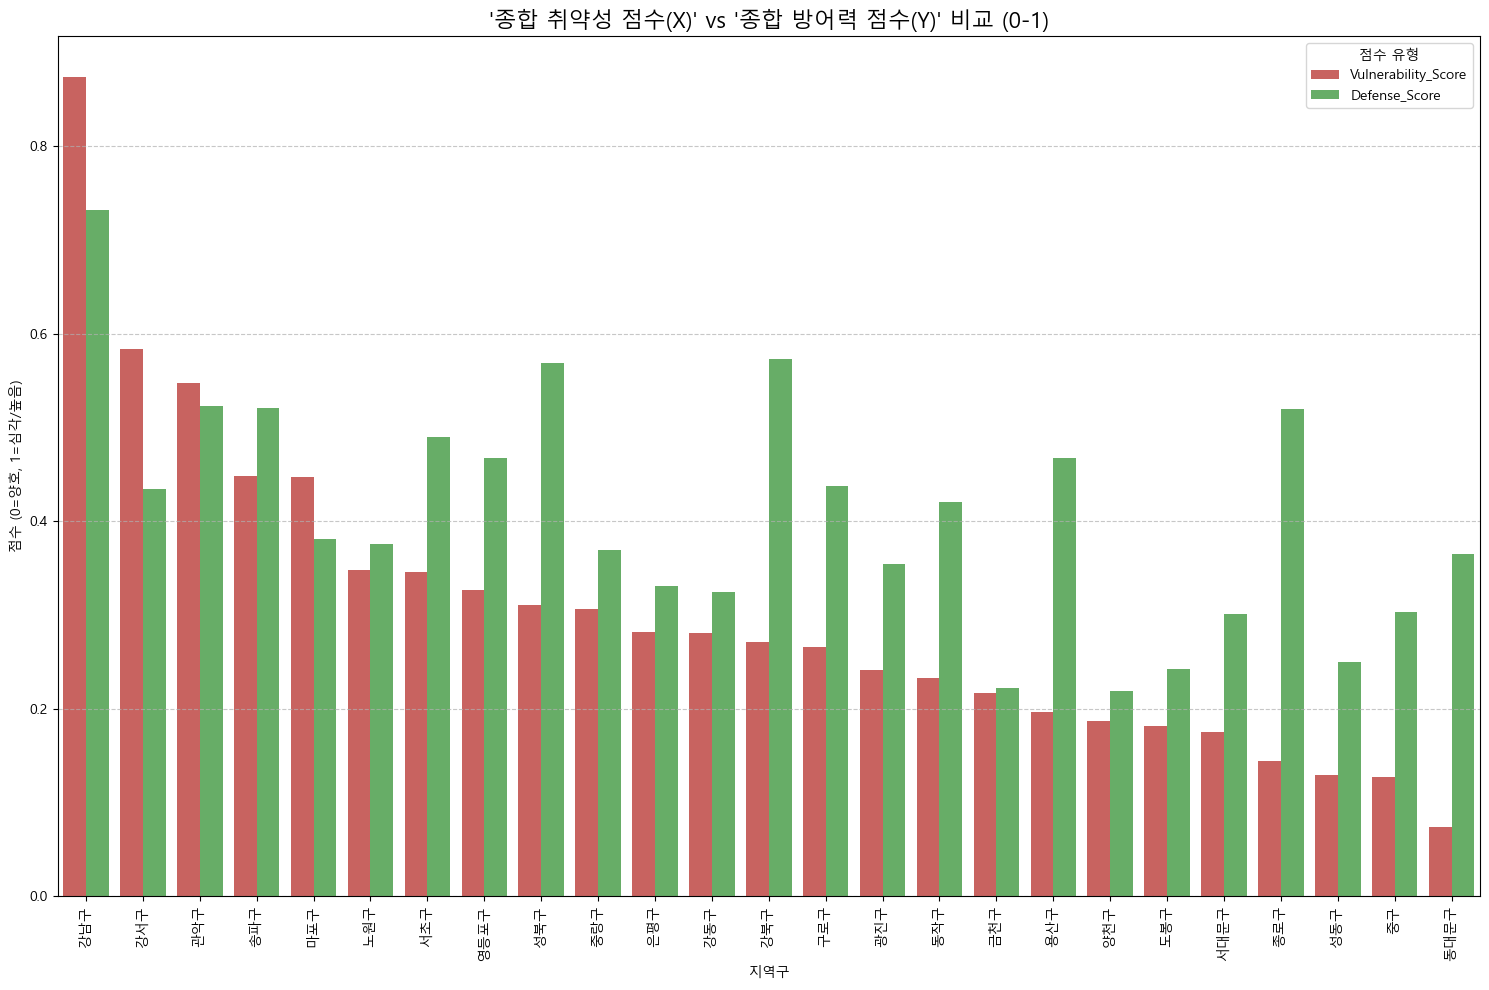

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

def calculate_scores():
    """
    [2단계: 취약성(X) 및 방어력(Y) 점수 계산]
    
    -   입력: 1단계에서 저장된 'data_01_merged.pkl' 파일
    -   출력: 'data_02_scores.pkl' (점수 계산 완료된 데이터),
              'scores_comparison_barchart.png' (시각화 차트)
    
    -   핵심 로직:
        1. [취약성(X)] 변수들을 0~1 사이로 정규화(Scaling)합니다.
           (예: 성범죄건수가 가장 많은 '강남구' = 1.0, 가장 적은 '도봉구' = 0.0)
        2. 정규화된 [취약성(X)] 변수들의 평균을 내어 'Vulnerability_Score' (종합 취약성 점수)를 만듭니다.
        3. [방어력(Y)] 변수들을 0~1 사이로 정규화합니다.
        4. 정규화된 [방어력(Y)] 변수들의 평균을 내어 'Defense_Score' (종합 방어력 점수)를 만듭니다.
        5. 두 점수를 비교하는 막대 차트를 생성하여 저장합니다.
    """
    print("--- 2. '취약성(X)' 및 '방어력(Y)' 점수 계산 시작 --- ")
    
    # --- 2-1: 한글 폰트 설정 ---
    try:
        if os.name == 'nt': # Windows
            font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        elif os.name == 'posix': # macOS or Linux
            font_name = 'AppleGothic' # macOS
        else:
            font_name = None
        
        if font_name:
            plt.rc('font', family=font_name)
        else:
            print("경고: 한글 폰트(Malgun Gothic 또는 AppleGothic)를 찾을 수 없어 차트의 한글이 깨질 수 있습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생 (무시하고 진행): {e}")

    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    
    # --- 2-2: 경로 설정 ---
    # CWD(data/src)에서 상위 폴더(data/)에 있는 pkl을 읽고 pkl, png를 저장
    cwd = os.getcwd()
    input_path = os.path.join(cwd, '..', 'data_01_merged.pkl') 
    output_path = os.path.join(cwd, '..', 'data_02_scores.pkl')
    output_image_path = os.path.join(cwd, '..', 'scores_comparison_barchart.png') # 시각화 차트 저장 경로
    
    try:
        if not os.path.exists(input_path):
            print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
            print("먼저 01_load_data 스크립트(셀)를 성공적으로 실행하세요.")
            return None
            
        df = pd.read_pickle(input_path)
        
        # --- 2-3: 변수 리스트 정의 ---
        # [취약성(X)] 변수들
        vulnerability_vars = ['Sexual_Crime_Count', 'Sexual_Assault_Risk_Index', 'Elderly_Women_Alone']
        
        # [방어력(Y)] 변수들
        defense_vars = ['CCTV', 'Safety_Bell', 'Police_Station', 'Police_Center', 'Police_Officers']
        
        # --- 2-4: 0~1 정규화 (Min-Max Scaling) ---
        scaler = MinMaxScaler()
        
        # [취약성(X)] 변수들을 정규화
        df_vuln_scaled = scaler.fit_transform(df[vulnerability_vars])
        df_vuln_scaled = pd.DataFrame(df_vuln_scaled, columns=[f'{col}_Scaled' for col in vulnerability_vars], index=df.index)
        
        # [방어력(Y)] 변수들을 정규화
        df_def_scaled = scaler.fit_transform(df[defense_vars])
        df_def_scaled = pd.DataFrame(df_def_scaled, columns=[f'{col}_Scaled' for col in defense_vars], index=df.index)
        
        # --- 2-5: '종합 점수' 계산 (평균) ---
        df['Vulnerability_Score'] = df_vuln_scaled.mean(axis=1)
        df['Defense_Score'] = df_def_scaled.mean(axis=1)
        
        # 계산된 점수를 원본 df에 병합 (다음 단계를 위해)
        df = pd.concat([df, df_vuln_scaled, df_def_scaled], axis=1)
        
        print("--- ✅ 2. 종합 점수 계산 완료 ---")
        print(df[['Vulnerability_Score', 'Defense_Score']].head())
        
        # --- 2-6: 데이터 저장 ---
        df.to_pickle(output_path)
        print(f"[저장 완료] 'data_02_scores.pkl' 파일이 상위 폴더({os.path.dirname(output_path)})에 생성되었습니다.")
        
        # --- 2-7: [시각화 추가] 점수 비교 막대 차트 생성 ---
        print("--- 2. 시각화 시작: '취약성 점수' vs '방어력 점수' ---")
        
        df_plot = df[['Vulnerability_Score', 'Defense_Score']].sort_values(by='Vulnerability_Score', ascending=False)
        
        # melt를 사용하여 '지역구', '점수 유형', '값' 형태로 변형
        df_plot_melted = df_plot.reset_index().melt(id_vars='지역구', var_name='점수 유형', value_name='점수 (0-1)')
        
        plt.figure(figsize=(15, 10))
        sns.barplot(
            data=df_plot_melted, 
            x='지역구', 
            y='점수 (0-1)', 
            hue='점수 유형', # 'Vulnerability_Score'와 'Defense_Score'를 색상으로 구분
            palette={'Vulnerability_Score': '#D9534F', 'Defense_Score': '#5CB85C'} # 취약성: 붉은색, 방어력: 녹색
        )
        plt.title("'종합 취약성 점수(X)' vs '종합 방어력 점수(Y)' 비교 (0-1)", fontsize=16)
        plt.ylabel("점수 (0=양호, 1=심각/높음)")
        plt.xlabel("지역구")
        plt.xticks(rotation=90) # 지역구 이름 세로로 표시
        plt.legend(title='점수 유형')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout() # 그래프가 잘리지 않도록 조정
        
        # 이미지 파일로 저장
        plt.savefig(output_image_path, dpi=300)
        print(f"[시각화 저장 완료] 'scores_comparison_barchart.png' 파일이 상위 폴더({os.path.dirname(output_image_path)})에 생성되었습니다.")
        # plt.show() # .py 스크립트에서는 주석 처리
        
        return df

    except ImportError:
        print("오류: 'seaborn' 또는 'matplotlib' 라이브러리가 필요합니다.")
        print("터미널에서 'pip install seaborn matplotlib'을 실행해주세요.")
        return None
    except FileNotFoundError:
        print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
        print("먼저 01_load_data 스크립트(셀)를 성공적으로 실행하세요.")
        return None
    except Exception as e:
        print(f"2단계 실행 중 오류 발생: {e}")
        return None

if __name__ == "__main__":
    
    # pandas 출력 옵션 설정 (터미널에서 전체를 보기 위함)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    calculate_scores()



## 3단계: '개선 시급도 지수' 산출

--- 3. '개선 시급도 지수' (원시 점수) 산출 시작 --- 
--- ✅ 3. '시급도 지수' (원시) 계산 완료 ---
     Vulnerability_Score  Defense_Score  Urgency_Index
지역구                                                   
강남구             0.873612       0.732176       0.141436
강동구             0.280470       0.324322      -0.043852
강북구             0.271041       0.572992      -0.301950
강서구             0.583314       0.433971       0.149343
관악구             0.546935       0.522405       0.024530
[저장 완료] 'data_03_urgency.pkl' 파일이 상위 폴더(c:\Users\user\Desktop\경진대회\SORA_Project\src\..)에 생성되었습니다.
--- 3. 시각화 시작: '원시 시급도 지수' 순위 ---


C:\Users\user\AppData\Local\Temp\ipykernel_12968\1229960926.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


[시각화 저장 완료] 'urgency_index_raw_barchart.png' 파일이 상위 폴더(c:\Users\user\Desktop\경진대회\SORA_Project\src\..)에 생성되었습니다.


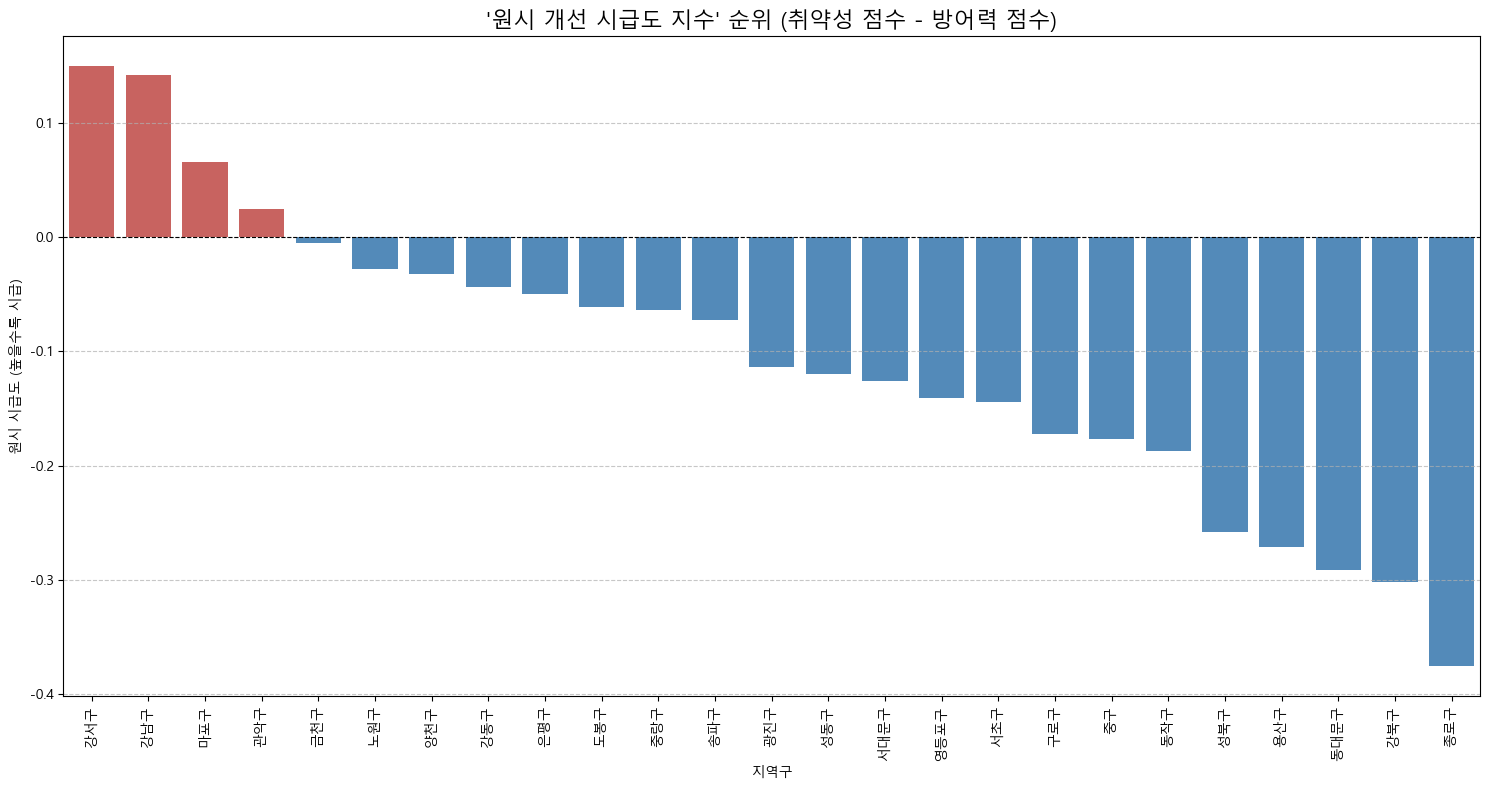

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

def calculate_urgency():
    """
    [3단계: '개선 시급도 지수' 산출 (원시 점수)]
    
    -   입력: 2단계에서 저장된 'data_02_scores.pkl' 파일
    -   출력: 'data_03_urgency.pkl' (시급도 계산 완료된 데이터),
              'urgency_index_raw_barchart.png' (시각화 차트)
    
    -   핵심 로직:
        1. 2단계에서 계산한 'Vulnerability_Score' (종합 취약성 점수)와 
           'Defense_Score' (종합 방어력 점수)를 불러옵니다.
        2. 가설에 따라 'Urgency_Index' (원시 시급도 지수)를 계산합니다.
           [시급도 = 종합 취약성(X) 점수 - 종합 방어력(Y) 점수]
        3. 'Urgency_Index'가 높을수록 방어력에 비해 취약성이 높아 개선이 시급한 지역임을 의미합니다.
        4. 원시 시급도 지수를 막대 차트로 시각화하여 저장합니다.
    """
    print("--- 3. '개선 시급도 지수' (원시 점수) 산출 시작 --- ")
    
    # --- 3-1: 한글 폰트 설정 ---
    try:
        if os.name == 'nt': # Windows
            font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        elif os.name == 'posix': # macOS or Linux
            font_name = 'AppleGothic' # macOS
        else:
            font_name = None
        
        if font_name:
            plt.rc('font', family=font_name)
        else:
            print("경고: 한글 폰트(Malgun Gothic 또는 AppleGothic)를 찾을 수 없어 차트의 한글이 깨질 수 있습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생 (무시하고 진행): {e}")

    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    
    # --- 3-2: 경로 설정 ---
    # CWD(data/src)에서 상위 폴더(data/)에 있는 pkl을 읽고 pkl, png를 저장
    cwd = os.getcwd()
    input_path = os.path.join(cwd, '..', 'data_02_scores.pkl') 
    output_path = os.path.join(cwd, '..', 'data_03_urgency.pkl')
    output_image_path = os.path.join(cwd, '..', 'urgency_index_raw_barchart.png') # 시각화 차트 저장 경로
    
    try:
        if not os.path.exists(input_path):
            print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
            print("먼저 02_calculate_scores 스크립트(셀)를 성공적으로 실행하세요.")
            return None
            
        df = pd.read_pickle(input_path)
        
        # --- 3-3: '시급도 지수' (원시) 계산 ---
        # 가설: 시급도 = 종합 취약성(X) 점수 - 종합 방어력(Y) 점수
        df['Urgency_Index'] = df['Vulnerability_Score'] - df['Defense_Score']
        
        print("--- ✅ 3. '시급도 지수' (원시) 계산 완료 ---")
        print(df[['Vulnerability_Score', 'Defense_Score', 'Urgency_Index']].head())
        
        # --- 3-4: 데이터 저장 ---
        df.to_pickle(output_path)
        print(f"[저장 완료] 'data_03_urgency.pkl' 파일이 상위 폴더({os.path.dirname(output_path)})에 생성되었습니다.")
        
        # --- 3-5: [시각화 추가] 원시 시급도 지수 막대 차트 생성 ---
        print("--- 3. 시각화 시작: '원시 시급도 지수' 순위 ---")
        
        df_plot = df[['Urgency_Index']].sort_values(by='Urgency_Index', ascending=False)
        
        plt.figure(figsize=(15, 8))
        # 'Urgency_Index' 값에 따라 색상을 다르게 (0보다 크면 붉은색, 작으면 푸른색)
        colors = ['#D9534F' if x > 0 else '#428BCA' for x in df_plot['Urgency_Index']]
        
        sns.barplot(
            data=df_plot, 
            x=df_plot.index, 
            y='Urgency_Index',
            palette=colors # 색상 적용
        )
        plt.title("'원시 개선 시급도 지수' 순위 (취약성 점수 - 방어력 점수)", fontsize=16)
        plt.ylabel("원시 시급도 (높을수록 시급)")
        plt.xlabel("지역구")
        plt.xticks(rotation=90) # 지역구 이름 세로로 표시
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # 0점 기준선
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout() # 그래프가 잘리지 않도록 조정
        
        # 이미지 파일로 저장
        plt.savefig(output_image_path, dpi=300)
        print(f"[시각화 저장 완료] 'urgency_index_raw_barchart.png' 파일이 상위 폴더({os.path.dirname(output_image_path)})에 생성되었습니다.")
        # plt.show() # .py 스크립트에서는 주석 처리
        
        return df

    except ImportError:
        print("오류: 'seaborn' 또는 'matplotlib' 라이브러리가 필요합니다.")
        print("터미널에서 'pip install seaborn matplotlib'을 실행해주세요.")
        return None
    except FileNotFoundError:
        print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
        print("먼저 02_calculate_scores 스크립트(셀)를 성공적으로 실행하세요.")
        return None
    except Exception as e:
        print(f"3단계 실행 중 오류 발생: {e}")
        return None

if __name__ == "__main__":
    
    # pandas 출력 옵션 설정 (터미널에서 전체를 보기 위함)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    calculate_urgency()



## 4단계: 최종 결과 확인 (0~100점 스케일링)

--- 4. 최종 결과 확인 (0-100점 스케일링) 시작 --- 

[--- 최종 인프라 개선 시급도 지수 순위 ---]
(100점에 가까울수록 개선이 시급한 지역입니다)
      Urgency_Index_Scaled  Urgency_Index  Vulnerability_Score  Defense_Score
지역구                                                                          
강서구             100.000000       0.149343             0.583314       0.433971
강남구              98.493393       0.141436             0.873612       0.732176
마포구              84.078829       0.065785             0.446789       0.381004
관악구              76.217994       0.024530             0.546935       0.522405
금천구              70.524273      -0.005352             0.216477       0.221829
노원구              66.252771      -0.027770             0.348110       0.375880
양천구              65.367166      -0.032418             0.186863       0.219281
강동구              63.188404      -0.043852             0.280470       0.324322
은평구              62.034499      -0.049908             0.281394       0.331302
도봉구              59.839102      -0.061430    

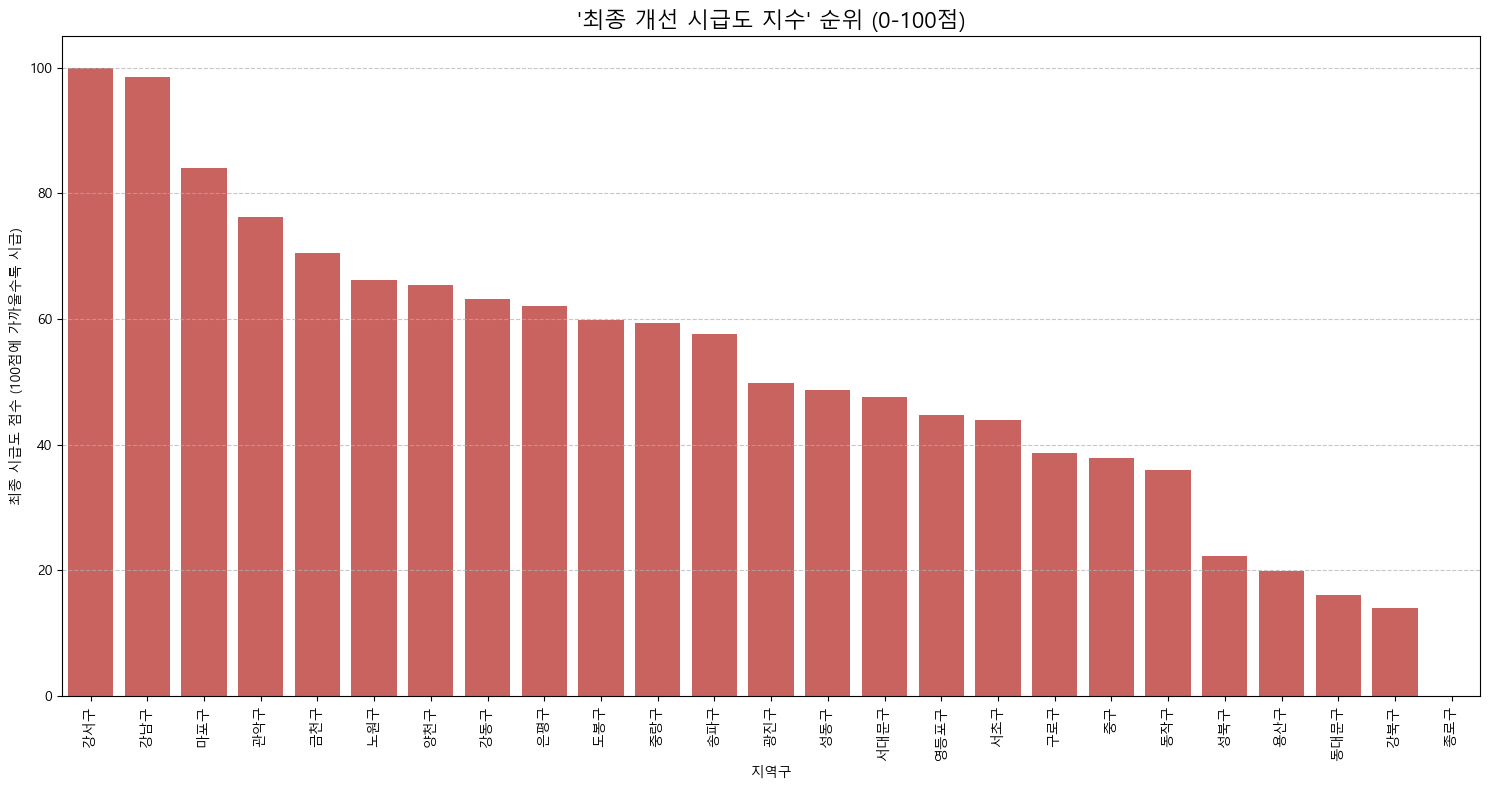

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

def show_final_results():
    """
    [4단계: 최종 결과 확인 (0-100점 스케일링)]
    
    -   입력: 3단계에서 저장된 'data_03_urgency.pkl' 파일
    -   출력: 'data_04_results.pkl' (최종 결과 데이터),
              'urgency_index_scaled_barchart.png' (시각화 차트),
              터미널에 최종 순위표 출력
    
    -   핵심 로직:
        1. 3단계에서 계산한 'Urgency_Index' (예: -0.5 ~ +0.3)는
           직관적으로 이해하기 어렵습니다.
        2. 따라서 Min-Max 스케일링을 다시 사용하여,
           가장 시급한 지역을 100점, 가장 양호한 지역을 0점으로 변환합니다.
        3. 최종 0-100점 스케일링된 지수를 막대 차트로 시각화하여 저장합니다.
    """
    print("--- 4. 최종 결과 확인 (0-100점 스케일링) 시작 --- ")
    
    # --- 4-1: 한글 폰트 설정 ---
    try:
        if os.name == 'nt': # Windows
            font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        elif os.name == 'posix': # macOS or Linux
            font_name = 'AppleGothic' # macOS
        else:
            font_name = None
        
        if font_name:
            plt.rc('font', family=font_name)
        else:
            print("경고: 한글 폰트(Malgun Gothic 또는 AppleGothic)를 찾을 수 없어 차트의 한글이 깨질 수 있습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생 (무시하고 진행): {e}")

    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    
    # --- 4-2: 경로 설정 ---
    # CWD(data/src)에서 상위 폴더(data/)에 있는 pkl을 읽고 pkl, png를 저장
    cwd = os.getcwd()
    input_path = os.path.join(cwd, '..', 'data_03_urgency.pkl') 
    output_path = os.path.join(cwd, '..', 'data_04_results.pkl') # 6단계 지도 시각화에서 사용할 파일
    output_image_path = os.path.join(cwd, '..', 'urgency_index_scaled_barchart.png') # 시각화 차트 저장 경로
    
    try:
        if not os.path.exists(input_path):
            print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
            print("먼저 03_calculate_urgency.py 스크립트(셀)를 성공적으로 실행하세요.")
            return None
            
        df = pd.read_pickle(input_path)
        
        # --- 4-3: 0~100점 스케일링 ---
        # (feature_range=(0, 100)) 옵션을 주어 0~100점 척도로 변환
        scaler = MinMaxScaler(feature_range=(0, 100))
        
        # .values.reshape(-1, 1)을 사용하여 2D 배열로 변환한 뒤 fit_transform 적용
        df['Urgency_Index_Scaled'] = scaler.fit_transform(df[['Urgency_Index']])
        
        # --- 4-4: 최종 결과 정렬 및 출력 ---
        # 분석에 사용된 핵심 점수들만 모아서 보기 쉽게 정렬합니다.
        cols_to_show = [
            'Urgency_Index_Scaled', # 0~100점 (최종 시급도)
            'Urgency_Index',        # 원시 시급도 (취약성-방어력)
            'Vulnerability_Score',  # 종합 취약성(X) 점수
            'Defense_Score'         # 종합 방어력(Y) 점수
        ]
        
        # 'Urgency_Index_Scaled' (최종 시급도)가 높은 순(ascending=False)으로 정렬
        df_final_result = df.sort_values(by='Urgency_Index_Scaled', ascending=False)
        
        print("\n[--- 최종 인프라 개선 시급도 지수 순위 ---]")
        print("(100점에 가까울수록 개선이 시급한 지역입니다)")
        print(df_final_result[cols_to_show])
        
        # --- 4-5: [수정] 데이터 저장 ---
        # 6단계 지도 시각화에서 사용할 수 있도록 0-100점 스케일링이 완료된 df를 저장합니다.
        df_final_result.to_pickle(output_path)
        print(f"\n[저장 완료] 'data_04_results.pkl' 파일이 상위 폴더({os.path.dirname(output_path)})에 생성되었습니다.")

        # --- 4-6: [시각화 추가] 최종 시급도 지수 (0-100점) 막대 차트 생성 ---
        print("--- 4. 시각화 시작: '최종 시급도 지수 (0-100점)' 순위 ---")
        
        # df_final_result는 이미 정렬되어 있음
        df_plot = df_final_result[['Urgency_Index_Scaled']]
        
        plt.figure(figsize=(15, 8))
        
        # 0~100점 척도이므로 0보다 작은 값은 없음. 단일 색상 사용.
        sns.barplot(
            data=df_plot, 
            x=df_plot.index, 
            y='Urgency_Index_Scaled',
            color='#D9534F' # 붉은색 계열
        )
        plt.title("'최종 개선 시급도 지수' 순위 (0-100점)", fontsize=16)
        plt.ylabel("최종 시급도 점수 (100점에 가까울수록 시급)")
        plt.xlabel("지역구")
        plt.xticks(rotation=90) # 지역구 이름 세로로 표시
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout() # 그래프가 잘리지 않도록 조정
        
        # 이미지 파일로 저장
        plt.savefig(output_image_path, dpi=300)
        print(f"[시각화 저장 완료] 'urgency_index_scaled_barchart.png' 파일이 상위 폴더({os.path.dirname(output_image_path)})에 생성되었습니다.")
        # plt.show() # .py 스크립트에서는 주석 처리
        
        return df_final_result

    except ImportError:
        print("오류: 'seaborn' 또는 'matplotlib' 라이브러리가 필요합니다.")
        print("터미널에서 'pip install seaborn matplotlib'을 실행해주세요.")
        return None
    except FileNotFoundError:
        print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
        print("먼저 03_calculate_urgency.py 스크립트(셀)를 성공적으로 실행하세요.")
        return None
    except Exception as e:
        print(f"4단계 실행 중 오류 발생: {e}")
        return None

if __name__ == "__main__":
    
    # pandas 출력 옵션 설정 (터미널에서 전체를 보기 위함)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    show_final_results()



## 5단계: 상관관계 시각화 (Heatmap)

--- 5. 상관관계 시각화 및 계수표 출력 시작 --- 
--- ✅ 5. 상관관계 시각화 완료 ---
[저장 완료] 'correlation_heatmap.png' 파일이 상위 폴더(c:\Users\user\Desktop\경진대회\SORA_Project\src\..)에 생성되었습니다.

[--- 상관관계 계수표 (p-value 포함) ---]
(* p < 0.05, ** p < 0.01)
             [취약성X] 성범죄건수  성폭력위험지수   여성독거노인 [방어력Y] CCTV      안심벨  지구대/파출소     치안센터     경찰관수 종합 취약성(X) 점수 종합 방어력(Y) 점수
[취약성X] 성범죄건수      1.000**  0.895**    0.189      0.504*   0.460*    0.258    0.116  0.542**      0.874**      0.676**
성폭력위험지수           0.895**  1.000**    0.316     0.603**  0.550**    0.194   -0.067  0.548**      0.923**      0.649**
여성독거노인              0.189    0.316  1.000**       0.209    0.222   -0.153    0.079    0.266      0.610**        0.232
[방어력Y] CCTV        0.504*  0.603**    0.209     1.000**  0.722**    0.185   -0.086    0.189      0.549**      0.730**
안심벨                0.460*  0.550**    0.222     0.722**  1.000**    0.283    0.051    0.177      0.513**      0.828**
지구대/파출소             0.258    0.194   -0.153       0.185    0.283  1.000**

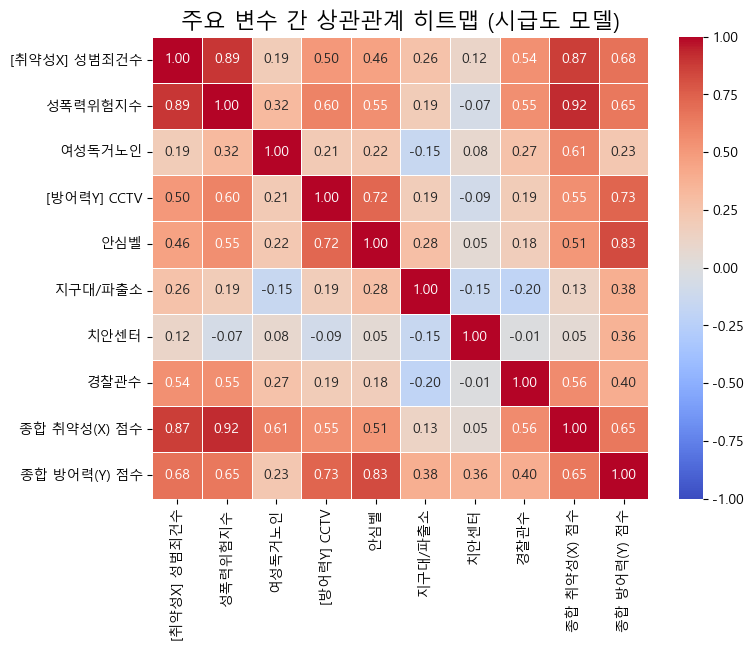

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy import stats # P-value 계산을 위해 import

def visualize_correlations():
    """
    [5단계: 상관관계 시각화 (Heatmap) 및 계수표 출력]
    
    -   입력: 2단계에서 저장된 'data_02_scores.pkl' 파일
    -   출력: 'correlation_heatmap.png' 이미지 파일 및 터미널에 상관계수표 출력
    
    -   목표 (EDA: 탐색적 데이터 분석):
        '시급도' 모델이 타당한지 검증합니다.
        
    -   확인 사항:
        1. [취약성(X)] 변수들끼리 서로 양의 상관관계(붉은색)를 보이는가? (예: 성범죄건수와 독거노인)
        2. [방어력(Y)] 변수들끼리 서로 양의 상관관계(붉은색)를 보이는가? (예: CCTV와 안심벨)
        3. [취약성(X)]과 [방어력(Y)]은 어떤 관계를 보이는가?
            (만약 붉은색(양)이면 -> 위험한 곳에 인프라가 '잘' 깔린 것)
            (만약 푸른색(음)이면 -> 위험한 곳에 인프라가 '부족'한 것)
            
    -   p-value (별표) 의미:
        (* p < 0.05, ** p < 0.01)
        -   * (별표 1개): p < 0.05 (유의수준 5% 미만)
            "두 변수 간의 관계가 우연히 발생했을 확률이 5% 미만이다." (즉, 95% 신뢰수준에서 유의미하다)
        -   ** (별표 2개): p < 0.01 (유의수준 1% 미만)
            "두 변수 간의 관계가 우연히 발생했을 확률이 1% 미만이다." (즉, 99% 신뢰수준에서 매우 유의미하다)
    """
    print("--- 5. 상관관계 시각화 및 계수표 출력 시작 --- ")
    
    # --- 5-1: 한글 폰트 설정 ---
    try:
        if os.name == 'nt': # Windows
            font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        elif os.name == 'posix': # macOS or Linux
            font_name = 'AppleGothic' # macOS
        else:
            font_name = None
        
        if font_name:
            plt.rc('font', family=font_name)
        else:
            print("경고: 한글 폰트(Malgun Gothic 또는 AppleGothic)를 찾을 수 없어 한글이 깨질 수 있습니다.")
    except Exception as e:
        print(f"폰트 설정 중 오류 발생 (무시하고 진행): {e}")

    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    
    # --- 5-2: 경로 설정 ---
    cwd = os.getcwd()
    input_path = os.path.join(cwd, '..', 'data_02_scores.pkl') # 상위 폴더(data/)의 2단계 결과물 사용
    output_image_path = os.path.join(cwd, '..', 'correlation_heatmap.png') # 상위 폴더(data/)에 저장
    
    try:
        if not os.path.exists(input_path):
            print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
            print("먼저 1, 2단계 스크립트(셀)를 성공적으로 실행하세요.")
            return None
            
        df = pd.read_pickle(input_path)
        
        # --- 5-3: 시각화할 변수 선택 ---
        vulnerability_vars = ['Sexual_Crime_Count', 'Sexual_Assault_Risk_Index', 'Elderly_Women_Alone']
        defense_vars = ['CCTV', 'Safety_Bell', 'Police_Station', 'Police_Center', 'Police_Officers']
        
        final_scores = ['Vulnerability_Score', 'Defense_Score']
        cols_to_correlate = vulnerability_vars + defense_vars + final_scores
        
        # 원본 데이터프레임에서 NaN 값이 포함된 행을 제거한 복사본을 만듭니다.
        df_corr_raw = df[cols_to_correlate].dropna()
        
        # [수정] 컬럼명을 간결하게 변경합니다. (각 그룹의 첫 번째 변수에만 접두사 적용)
        rename_dict = {
            'Sexual_Crime_Count': '[취약성X] 성범죄건수', # 그룹 첫 번째
            'Sexual_Assault_Risk_Index': '성폭력위험지수',
            'Elderly_Women_Alone': '여성독거노인',
            
            'CCTV': '[방어력Y] CCTV', # 그룹 첫 번째
            'Safety_Bell': '안심벨',
            'Police_Station': '지구대/파출소',
            'Police_Center': '치안센터',
            'Police_Officers': '경찰관수',
            
            'Vulnerability_Score': '종합 취약성(X) 점수', # 종합 점수는 (X), (Y) 표시 유지
            'Defense_Score': '종합 방어력(Y) 점수'
        }
        df_corr = df_corr_raw.rename(columns=rename_dict)

        # --- 5-4: 상관 행렬 계산 (히트맵용) ---
        corr_matrix = df_corr.corr()

        # 히트맵(Heatmap) 생성
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr_matrix, 
            annot=True,     # 셀 안에 숫자 표시
            fmt='.2f',      # 소수점 둘째 자리까지
            cmap='coolwarm',# 색상 맵 (양의 상관: 붉은색, 음의 상관: 푸른색)
            vmin=-1, vmax=1, # 최소/최대 값
            linewidths=.5    # 셀 사이 간격
        )
        plt.title('주요 변수 간 상관관계 히트맵 (시급도 모델)', fontsize=16)
        
        # --- 5-5: 결과 저장 및 출력 ---
        plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
        
        print("--- ✅ 5. 상관관계 시각화 완료 ---")
        print(f"[저장 완료] 'correlation_heatmap.png' 파일이 상위 폴더({os.path.dirname(output_image_path)})에 생성되었습니다.")
        
        print("\n[--- 상관관계 계수표 (p-value 포함) ---]")
        print("(* p < 0.05, ** p < 0.01)")
        
        cols = df_corr.columns
        # dtype=object로 변경하여 문자열(예: '0.50**')을 저장할 수 있도록 합니다.
        formatted_corr_table = pd.DataFrame(index=cols, columns=cols, dtype=object) 
        
        for r in cols:
            for c in cols:
                # .values를 사용하여 pandas Series가 아닌 1D NumPy 배열을 전달합니다.
                result = stats.pearsonr(df_corr[r].values, df_corr[c].values)
                
                corr = float(result.statistic)
                p_value = float(result.pvalue)

                # p-value에 따라 *, **를 붙이는 함수
                if pd.isna(corr) or pd.isna(p_value):
                     formatted_corr = "N/A"
                else:
                    formatted_corr = f"{corr:.3f}" # 소수점 3자리
                    if p_value < 0.01:
                        formatted_corr += "**"
                    elif p_value < 0.05:
                        formatted_corr += "*"
                
                formatted_corr_table.loc[r, c] = formatted_corr
        
        print(formatted_corr_table) # 최종 표 출력
        
        return formatted_corr_table

    except ImportError:
        print("오류: 'seaborn' 또는 'matplotlib' 라이브러리가 필요합니다.")
        print("터미널에서 'pip install seaborn matplotlib'을 실행해주세요.")
        return None
    except Exception as e:
        print(f"5단계 실행 중 오류 발생: {e}")
        return None

if __name__ == "__main__":
    # pandas 출력 옵션 설정
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    correlation_matrix = visualize_correlations()



## 6단계: '개선 시급도 지수' 지도 시각화 (Folium)

In [ ]:
import pandas as pd
import os
import folium
import json
import requests
from folium.features import DivIcon
from shapely.geometry import shape  # 중심 좌표 계산용

def visualize_map_final():
    print("--- 지도 시각화 (중앙 좌표 자동계산 버전) ---")

    cwd = os.getcwd()
    input_path = os.path.join(cwd, '..', 'data_04_results.pkl')
    output_map_path = os.path.join(cwd, '..', 'seoul_urgency_map_Final.html')

    # 📝 이름 매핑 (구 제거)
    name_mapping = {}

    try:
        if not os.path.exists(input_path):
            print(f"오류: '{input_path}' 파일을 찾을 수 없습니다.")
            return None

        df_results = pd.read_pickle(input_path)
        if '지역구' not in df_results.columns:
            df_results = df_results.reset_index()
            if 'index' in df_results.columns and '지역구' not in df_results.columns:
                df_results = df_results.rename(columns={'index': '지역구'})

        df_results['Urgency_Index_Scaled_Formatted'] = df_results['Urgency_Index_Scaled'].round(1)

        geo_data_url = (
            "https://raw.githubusercontent.com/southkorea/seoul-maps/"
            "master/kostat/2013/json/seoul_municipalities_geo_simple.json"
        )
        geo_json_data = requests.get(geo_data_url).json()

        # 🧭 중심 좌표 계산
        gu_centers = {}
        for feature in geo_json_data['features']:
            gu_name = feature['properties']['name']
            polygon = shape(feature['geometry'])
            centroid = polygon.centroid
            gu_centers[gu_name] = [centroid.y, centroid.x]
            name_mapping[gu_name] = gu_name.replace("구", "")  # 구 제거

        # 점수 병합
        data_dict_score = df_results.set_index('지역구')['Urgency_Index_Scaled_Formatted']
        for feature in geo_json_data['features']:
            gu_name = feature['properties']['name']
            feature['properties']['Urgency_Index_Scaled_Formatted'] = data_dict_score.get(gu_name, "N/A")

        # 지도 생성
        seoul_map = folium.Map(location=[37.56, 126.98], zoom_start=10.5, tiles="CartoDB positron")

        # Choropleth 색상
        folium.Choropleth(
            geo_data=geo_json_data,
            data=df_results,
            columns=['지역구', 'Urgency_Index_Scaled'],
            key_on='feature.properties.name',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0,
            legend_name='인프라 개선 시급도 지수 (0-100점)',
        ).add_to(seoul_map)

        # 경계선 + 하이라이트
        folium.GeoJson(
            geo_json_data,
            style_function=lambda x: {
                'fillOpacity': 0,
                'color': 'grey',
                'weight': 0.5,
                'opacity': 0.5
            },
            highlight_function=lambda x: {
                'fillOpacity': 0.3,
                'color': 'black',
                'weight': 2,
            },
            name="경계 및 팝업"
        ).add_to(seoul_map)

        # 📌 라벨
        for _, row in df_results.iterrows():
            gu_name = row['지역구']
            if gu_name in gu_centers:
                center_coord = gu_centers[gu_name]
                display_name = name_mapping[gu_name]
                score = row['Urgency_Index_Scaled_Formatted']

                icon_html = f"""
                <div style="
                    font-size: 11px;
                    font-weight: bold;
                    color: #222;
                    background-color: rgba(255, 255, 255, 0.7);
                    border-radius: 6px;
                    padding: 2px 6px;
                    white-space: nowrap;
                    text-align: center;
                ">
                    {display_name}<br>
                    <span style="font-size: 12px;">{score}</span>
                </div>
                """

                folium.Marker(
                    location=center_coord,
                    icon=DivIcon(
                        icon_size=(90, 40),
                        icon_anchor=(45, 20),
                        html=icon_html,
                    )
                ).add_to(seoul_map)

        seoul_map.save(output_map_path)
        print(f"--- ✅ 저장 완료: {output_map_path} ---")
        return seoul_map

    except Exception as e:
        print(f"오류 발생: {e}")
        return None

if __name__ == "__main__":
    map_object = visualize_map_final()


--- 지도 시각화 (중앙 좌표 자동계산 버전) ---
--- ✅ 저장 완료: c:\Users\user\Desktop\경진대회\SORA_Project\src\..\seoul_urgency_map_Final.html ---
